In [9]:
%%HTML
<link rel="stylesheet" type="text/css" href="my_rise.css">

### レトロネーザル香気パラメータ予測モデルの構築

###### 全部で593行

# 必要なツールの準備

In [1]:
import pandas as pd
import numpy as np

#smilesをmolオブジェクトへ
from rdkit import Chem

#分散＝0
from sklearn.feature_selection import VarianceThreshold

#要素の種類3種類以下かつ最多出現＞95％：出現回数のカウント
import collections

#相関係数＞0.8：川井さん作成
from correlation import CorrelationThreshold

#標準化
from sklearn.preprocessing import StandardScaler

#グラフ作成
import matplotlib.pyplot as plt
%matplotlib inline

#R^2スコア計算
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

# ファイルを読み込む

In [2]:
train3 = pd.read_csv ("train_3_removed.csv").iloc[0:89, 2:7].drop(['alpha_conc'], axis=1)
test3 = pd.read_csv ("test_3.csv").iloc[0:10, 2:7].drop(['alpha_conc'], axis=1)

data3 = pd.concat([train3, test3], axis=0).reset_index(drop=True)

addtest = pd.read_csv("602_FL_compounds.csv").iloc[:, 1:3]

## データはこんな感じ

In [3]:
data3

,Name,SMILES,Log_alpha,beta
0,"2,3-PENTANDIONE",CCC(=O)C(=O)C,0.199,1.020
1,2-ACETYL-3-ET. PYRAZINE,CCc1nccnc1C(=O)C,-0.089,0.715
2,2-ACETYL-5-ME. FURAN,CC(=O)c1oc(C)cc1,-0.345,0.874
3,2-ACETYLPYRROLE,CC(=O)c1ccc[nH]1,-1.250,0.485
4,2-METHYLPYRAZINE,Cc1cnccn1,0.076,0.707
5,4-ETHYL GUAIACOL,CCc1ccc(O)c(OC)c1,-0.796,1.144
6,ALCOHOL C-10,CCCCCCCCCCO,-0.188,2.083
7,BENZALD,O=Cc1ccccc1,0.473,2.583
8,BENZOTHIAZOLE,c1ccc2scnc2c1,-0.230,0.702
9,"BUTYROLACTONE, GAMMA",O=C1CCCO1,-1.306,0.712


# 説明変数（記述子）をつくる

#### 化合物　➡　構造情報（SMILES)　➡　記述子生成

## Training-Test dataset（実測した化合物）の記述子生成

In [4]:
#============================finger print 生成=============================
#================================PubChemDB=================================
from tqdm import tqdm
## Finger Printの計算------------------------------------------------------
## pubchempyFP generation-------------------------------------------------
import pubchempy as pcp
from pubchempy import Compound

data3_column = np.arange(44)
data3_cid = pd.DataFrame(columns=data3_column)

for i in tqdm(range(99)):
    smiles_i = data3['SMILES'][i]
    data3_cid_i = pcp.get_compounds(smiles_i, 'smiles', as_dataframe=True)
    data3_cid = pd.concat ([data3_cid, data3_cid_i], axis=0, sort=False)
    
### NaNのある列、数値以外のデータがある列を削除
data3_cid_na = data3_cid.dropna(how='all', axis=1)
data3_cid_simp = data3_cid_na.drop(columns=['atoms', 'bonds', 'canonical_smiles', 'isomeric_smiles',
                                    'inchikey', 'inchi', 'coordinate_type', 'iupac_name', 
                                    'molecular_formula', 'record', 'elements']).reset_index(drop=True)

100%|██████████| 99/99 [03:17<00:00,  3.05s/it]


## 記述子ってこんな感じ

In [5]:
data3_cid_simp

,atom_stereo_count,bond_stereo_count,cactvs_fingerprint,charge,complexity,covalent_unit_count,defined_atom_stereo_count,defined_bond_stereo_count,exact_mass,fingerprint,...,h_bond_donor_count,heavy_atom_count,isotope_atom_count,molecular_weight,monoisotopic_mass,rotatable_bond_count,tpsa,undefined_atom_stereo_count,undefined_bond_stereo_count,xlogp
0,0.0,0.0,1100000001100000001100000000000000000000000000...,0.0,94.3,1.0,0.0,0.0,100.052429,00000371C0603000000000000000000000000000000000...,...,0.0,7.0,0.0,100.12,100.052429,2.0,34.1,0.0,0.0,0.1
1,0.0,0.0,1100000001110011001000000000000000000000000000...,0.0,147.0,1.0,0.0,0.0,150.079313,00000371C0732000000000000000000000000000000000...,...,0.0,11.0,0.0,150.18,150.079313,2.0,42.8,0.0,0.0,0.6
2,0.0,0.0,1100000001100000001100000000000000000000000000...,0.0,120.0,1.0,0.0,0.0,124.052429,00000371C0603000000000000000000000000000000120...,...,0.0,9.0,0.0,124.14,124.052429,1.0,30.2,0.0,0.0,1.4
3,0.0,0.0,1000000001100010001000000000000000000000000000...,0.0,101.0,1.0,0.0,0.0,109.052764,0000037180622000000000000000000000000000000160...,...,1.0,8.0,0.0,109.13,109.052764,1.0,32.9,0.0,0.0,0.9
4,0.0,0.0,1000000001100011000000000000000000000000000000...,0.0,54.0,1.0,0.0,0.0,94.053098,0000037180630000000000000000000000000000000000...,...,0.0,7.0,0.0,94.11,94.053098,0.0,25.8,0.0,0.0,0.2
5,0.0,0.0,1100000001110000001100000000000000000000000000...,0.0,114.0,1.0,0.0,0.0,152.083730,00000371C0703000000000000000000000000000000000...,...,1.0,11.0,0.0,152.19,152.083730,2.0,29.5,0.0,0.0,1.7
6,0.0,0.0,1110000001110000001000000000000000000000000000...,0.0,61.9,1.0,0.0,0.0,158.167065,00000371E0702000000000000000000000000000000000...,...,1.0,11.0,0.0,158.28,158.167065,8.0,20.2,0.0,0.0,4.6
7,0.0,0.0,1000000001100000001000000000000000000000000000...,0.0,72.5,1.0,0.0,0.0,106.041865,0000037180602000000000000000000000000000000000...,...,0.0,8.0,0.0,106.12,106.041865,1.0,17.1,0.0,0.0,1.5
8,0.0,0.0,1000000001100010000000000000000001000000000000...,0.0,105.0,1.0,0.0,0.0,135.014270,0000037180620000400000000000000000000000000160...,...,0.0,9.0,0.0,135.19,135.014270,0.0,41.1,0.0,0.0,2.0
9,0.0,0.0,1000000001100000001100000000000000000000000000...,0.0,67.9,1.0,0.0,0.0,86.036779,0000037180603000000000000000000000000000000120...,...,0.0,6.0,0.0,86.09,86.036779,0.0,26.3,0.0,0.0,-0.6


## Fingerprintを扱いやすいよう整形する

#### cactvs_fingerprint

In [6]:
## pubchempyFP 整形--------------------------------------------------------
### 算出されたFingerPrint情報を抽出する
data3_cfp_column = np.arange(881)
data3_cid_cfp = pd.DataFrame(columns=data3_cfp_column)

for i in range(99):
    data3_cid_cfp_i = pd.DataFrame(list(data3_cid_simp['cactvs_fingerprint'][i])).T
    data3_cid_cfp = pd.concat([data3_cid_cfp, data3_cid_cfp_i], axis=0)
data3_cid_cfp = data3_cid_cfp.reset_index(drop=True)

cfp_column = []
for i in range(881):
    cfp_i = 'cfp_'+str(i)
    cfp_column.append(cfp_i)
    
data3_cid_cfp.columns = cfp_column

## Fingerprintを扱いやすいよう整形する

#### fingerprint

In [7]:
## pubchempyFP 整形--------------------------------------------------------
### 算出されたFingerPrint情報を抽出する
data3_fp_column = np.arange(230)
data3_cid_fp = pd.DataFrame(columns=data3_fp_column)

for i in range(99):
    data3_cid_fp_i = pd.DataFrame(list(data3_cid_simp['fingerprint'][i])).T
    data3_cid_fp = pd.concat([data3_cid_fp, data3_cid_fp_i], axis=0)

fp_column = []
for i in range(230):
    fp_i = 'fp_'+str(i)
    fp_column.append(fp_i)

data3_cid_fp.columns = fp_column
data3_cid_fp = data3_cid_fp.reset_index(drop=True).replace('A',1).replace('B',2).replace('C',3).replace('D',4).replace('E',5).replace('F',6)

### 元のデータのFingerPrintデータを削除し、一桁ずつばらしたFingerPrintを張り付ける
data3_pcp_pre = data3_cid_simp.drop(columns=['cactvs_fingerprint', 'fingerprint'])
data3_pcp = pd.concat([data3_pcp_pre, data3_cid_cfp, data3_cid_fp], axis=1)

## こんな風に変化した

In [27]:
pd.concat([data3_cid_simp["cactvs_fingerprint"], data3_cid_simp["fingerprint"]], axis=1).head()

,cactvs_fingerprint,fingerprint
0,1100000001100000001100000000000000000000000000...,00000371C0603000000000000000000000000000000000...
1,1100000001110011001000000000000000000000000000...,00000371C0732000000000000000000000000000000000...
2,1100000001100000001100000000000000000000000000...,00000371C0603000000000000000000000000000000120...
3,1000000001100010001000000000000000000000000000...,0000037180622000000000000000000000000000000160...
4,1000000001100011000000000000000000000000000000...,0000037180630000000000000000000000000000000000...


In [31]:
data3_pcp.iloc[:,19:].head()

,cfp_0,cfp_1,cfp_2,cfp_3,cfp_4,cfp_5,cfp_6,cfp_7,cfp_8,cfp_9,...,fp_220,fp_221,fp_222,fp_223,fp_224,fp_225,fp_226,fp_227,fp_228,fp_229
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## これでFingerprint情報も扱いやすくなった

In [8]:
data3_pcp

,atom_stereo_count,bond_stereo_count,charge,complexity,covalent_unit_count,defined_atom_stereo_count,defined_bond_stereo_count,exact_mass,h_bond_acceptor_count,h_bond_donor_count,...,fp_220,fp_221,fp_222,fp_223,fp_224,fp_225,fp_226,fp_227,fp_228,fp_229
0,0.0,0.0,0.0,94.3,1.0,0.0,0.0,100.052429,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,147.0,1.0,0.0,0.0,150.079313,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,120.0,1.0,0.0,0.0,124.052429,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,101.0,1.0,0.0,0.0,109.052764,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,54.0,1.0,0.0,0.0,94.053098,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,0.0,0.0,114.0,1.0,0.0,0.0,152.083730,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6,0.0,0.0,0.0,61.9,1.0,0.0,0.0,158.167065,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
7,0.0,0.0,0.0,72.5,1.0,0.0,0.0,106.041865,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,0.0,0.0,0.0,105.0,1.0,0.0,0.0,135.014270,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0.0,0.0,0.0,67.9,1.0,0.0,0.0,86.036779,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Additional-test dataset（未測定化合物）の記述子生成

In [9]:
#============================finger print 生成=============================
#=========addtestについても同様にPubChemDBから情報を引っ張ってくる============
#================================PubChemDB=================================
from tqdm import tqdm
## Finger Printの計算------------------------------------------------------
## pubchempyFP generation-------------------------------------------------

addtest_column = np.arange(1)
addtest_cid = pd.DataFrame(columns=addtest_column)

for i in tqdm(range(602)):
    smiles_i = addtest['SMILES'][i]
    addtest_cid_i = pcp.get_compounds(smiles_i, 'smiles', as_dataframe=True)
    addtest_cid = pd.concat ([addtest_cid, addtest_cid_i], axis=0, sort=False)
    
    pass

### NaNのある列、数値以外のデータがある列を削除
addtest_cid_na = addtest_cid.dropna(how='all', axis=1)
addtest_cid_simp = addtest_cid_na.drop(columns=['atoms', 'bonds', 'canonical_smiles', 'isomeric_smiles',
                                    'inchikey', 'inchi', 'coordinate_type', 'iupac_name', 
                                    'molecular_formula', 'record', 'elements']).reset_index(drop=True)

100%|██████████| 602/602 [19:35<00:00,  1.99s/it]


## Fingerprintを扱いやすいよう整形する

In [10]:
## pubchempyFP 整形--------------------------------------------------------
### 算出されたFingerPrint情報を抽出するdata3_column = np.arange(44)

addtest_cfp_column = np.arange(881)
addtest_cid_cfp = pd.DataFrame(columns=addtest_cfp_column)

for i in range(602):
    addtest_cid_cfp_i = pd.DataFrame(list(addtest_cid_simp['cactvs_fingerprint'][i])).T
    addtest_cid_cfp = pd.concat([addtest_cid_cfp, addtest_cid_cfp_i], axis=0)
addtest_cid_cfp = addtest_cid_cfp.reset_index(drop=True)

cfp_column = []
for i in range(881):
    cfp_i = 'cfp_'+str(i)
    cfp_column.append(cfp_i)
    
addtest_cid_cfp.columns = cfp_column
    
addtest_fp_column = np.arange(230)
addtest_cid_fp = pd.DataFrame(columns=addtest_fp_column)

for i in range(602):
    addtest_cid_fp_i = pd.DataFrame(list(addtest_cid_simp['fingerprint'][i])).T
    addtest_cid_fp = pd.concat([addtest_cid_fp, addtest_cid_fp_i], axis=0)

fp_column = []
for i in range(230):
    fp_i = 'fp_'+str(i)
    fp_column.append(fp_i)

addtest_cid_fp.columns = fp_column
addtest_cid_fp = addtest_cid_fp.reset_index(drop=True).replace('A',1).replace('B',2).replace('C',3).replace('D',4).replace('E',5).replace('F',6)

### 元のデータのFingerPrintデータを削除し、一桁ずつばらしたFingerPrintを張り付ける
addtest_pcp_pre = addtest_cid_simp.drop(columns=['cactvs_fingerprint', 'fingerprint'])
addtest_pcp = pd.concat([addtest_pcp_pre, addtest_cid_cfp, addtest_cid_fp], axis=1)

# 記述子を選別する

#### 削除対象の記述子
「全化合物に対して全てorほとんどが同じ記述子」や「記述子同士で相関の大きい記述子」

In [11]:
#===========================記述子削減（共通）==================================160行
from tqdm import tqdm

### train,test,addtestを分けて、共通残項を残す
train3_pcp = data3_pcp.iloc[0:89,:]
test3_pcp = data3_pcp.iloc[89:99,:]
addtest_pcp = addtest_pcp

## train-----------------------------------------------------------------------
## 分散=0の記述子削減-----------------------------------------------------------
### 計算した記述子のうち、全ての化合物に対して同じ値を返した（分散＝0）記述子を削除

vt = VarianceThreshold()
train3_vt_array = vt.fit_transform(train3_pcp)
train3_vt = pd.DataFrame(train3_vt_array, columns=train3_pcp.columns[vt.get_support()])

### 記述子1130→444


## ほぼ全ての化合物に対して同じ値を返した記述子を削除-----------------------------

### ある一つ記述子に含まれる計算値（要素）の種類が3種類以下
### かつ、最多要素の数が要素全体の95％以上、となる記述子を削除

list_cc = []
for item in tqdm(train3_vt.iteritems()):
### 各列を取り出す

    if len(collections.Counter(item[1])) <= 3:
    ### 各列の要素をカウントし、要素が3種類以下の列を抽出
    
        if max(collections.Counter(item[1]).values()) / len(item[1]) > 0.98:
        ### 最も出現数の多い要素がその列での要素全体の9割を超える場合
        
            list_cc.append(item[0])
            ### list_ccにカラム名を追加する
        else:
            pass
    else:
        pass                    
train3_cc = train3_vt.drop(list_cc, axis=1)

### list_ccに含まれるカラム名の列を消去
### 記述子→387


## 相関係数による記述子削減-----------------------------------------------------

### 相関係数の高い記述子対のうち、
### 他のすべての記述子との相関係数の絶対値の和が大きい方を消去

ct = CorrelationThreshold(0.95)
train3_ct = ct.fit_transform(train3_cc)

### 記述子→387

## test------------------------------------------------------------------------
## 分散=0の記述子削減-----------------------------------------------------------
### 計算した記述子のうち、全ての化合物に対して同じ値を返した（分散＝0）記述子を削除

vt = VarianceThreshold()
test3_vt_array = vt.fit_transform(test3_pcp)
test3_vt = pd.DataFrame(test3_vt_array, columns=test3_pcp.columns[vt.get_support()])

### 記述子1130→255


## ほぼ全ての化合物に対して同じ値を返した記述子を削除-----------------------------

### ある一つ記述子に含まれる計算値（要素）の種類が3種類以下
### かつ、最多要素の数が要素全体の95％以上、となる記述子を削除

list_cc = []
for item in tqdm(test3_vt.iteritems()):
### 各列を取り出す

    if len(collections.Counter(item[1])) <= 3:
    ### 各列の要素をカウントし、要素が3種類以下の列を抽出
    
        if max(collections.Counter(item[1]).values()) / len(item[1]) > 0.98:
        ### 最も出現数の多い要素がその列での要素全体の9割を超える場合
        
            list_cc.append(item[0])
            ### list_ccにカラム名を追加する
        else:
            pass
    else:
        pass                    
test3_cc = test3_vt.drop(list_cc, axis=1)

### list_ccに含まれるカラム名の列を消去
### 記述子→255


## 相関係数による記述子削減-----------------------------------------------------

### 相関係数の高い記述子対のうち、
### 他のすべての記述子との相関係数の絶対値の和が大きい方を消去

ct = CorrelationThreshold(0.95)
test3_ct = ct.fit_transform(test3_cc)

### 記述子255

## addtest_pcp-----------------------------------------------------------------
## 分散=0の記述子削減-----------------------------------------------------------
### 計算した記述子のうち、全ての化合物に対して同じ値を返した（分散＝0）記述子を削除

vt = VarianceThreshold()
addtest_vt_array = vt.fit_transform(addtest_pcp)
addtest_vt = pd.DataFrame(addtest_vt_array, columns=addtest_pcp.columns[vt.get_support()])

### 記述子1130→311


## ほぼ全ての化合物に対して同じ値を返した記述子を削除-----------------------------

### ある一つ記述子に含まれる計算値（要素）の種類が3種類以下
### かつ、最多要素の数が要素全体の95％以上、となる記述子を削除

list_cc = []
for item in tqdm(addtest_vt.iteritems()):
### 各列を取り出す

    if len(collections.Counter(item[1])) <= 3:
    ### 各列の要素をカウントし、要素が3種類以下の列を抽出
    
        if max(collections.Counter(item[1]).values()) / len(item[1]) > 0.98:
        ### 最も出現数の多い要素がその列での要素全体の9割を超える場合
        
            list_cc.append(item[0])
            ### list_ccにカラム名を追加する
        else:
            pass
    else:
        pass                    
addtest_cc = addtest_vt.drop(list_cc, axis=1)

### list_ccに含まれるカラム名の列を消去
### 記述子→311


## 相関係数による記述子削減-----------------------------------------------------

### 相関係数の高い記述子対のうち、
### 他のすべての記述子との相関係数の絶対値の和が大きい方を消去

ct = CorrelationThreshold(0.95)
addtest_ct = ct.fit_transform(addtest_cc)

### 記述子→311

## 共通項を出す----------------------------------------------------------------
common_columns = set(train3_ct.columns)&set(test3_ct.columns)&set(addtest_ct.columns)

## 共通項のみ残す--------------------------------------------------------------
train3_cm = train3_ct[common_columns]
test3_cm = test3_ct[common_columns]
addtest3_cm = addtest_ct[common_columns]

444it [00:00, 10051.28it/s]
255it [00:00, 11597.15it/s]
523it [00:00, 4798.09it/s]


## 残った記述子はこちら

In [12]:
train3_cm

,cfp_634,fp_115,fp_131,cfp_637,cfp_579,cfp_606,cfp_382,fp_53,fp_168,cfp_1,...,cfp_630,fp_10,cfp_597,cfp_441,cfp_824,complexity,fp_93,cfp_339,cfp_19,cfp_355
0,0,0,0,0,1,0,0,0,0,1,...,0,6,0,0,0,94.3,4,0,1,0
1,1,1,7,0,1,0,0,3,0,1,...,0,7,0,1,0,147,3,0,0,1
2,1,0,4,1,1,1,0,0,3,1,...,0,6,1,1,0,120,4,0,1,1
3,1,1,7,0,1,0,0,0,9,0,...,0,6,1,1,0,101,3,0,0,1
4,0,1,1,0,0,0,0,3,0,0,...,0,6,0,1,0,54,8,0,0,1
5,1,2,0,1,0,1,1,0,3,1,...,1,7,0,1,1,114,4,0,1,1
6,0,0,0,1,0,0,0,0,0,1,...,0,7,0,0,0,61.9,0,0,0,0
7,1,2,4,0,1,0,0,0,8,0,...,0,6,1,1,0,72.5,0,0,0,1
8,1,1,1,0,0,0,0,0,8,0,...,0,6,0,1,0,105,8,0,0,1
9,0,0,0,1,1,0,0,0,0,0,...,0,6,0,0,0,67.9,0,0,1,0


# 予測モデルを作る

#### Training Dataで学習　➡　Test Dataで予測精度を評価　➡　未測定化合物の予測

## まずは、回帰予測モデルを作るのに必要なデータを再度整理する

In [13]:
#==========================回帰に必要なデータを揃える===========================
## traindata------------------------------------------------------------------
train3_x = train3_cm
train3_y_La = pd.DataFrame(train3['Log_alpha'])
train3_y_b = pd.DataFrame(train3['beta'])

## testdata-------------------------------------------------------------------
test3_x = test3_cm
test3_y_La = pd.DataFrame(test3['Log_alpha'])
test3_y_b = pd.DataFrame(test3['beta'])

## addtestdata----------------------------------------------------------------
addtest3_x = addtest3_cm

## addtestのみを分離する---train_testのみのセットを作る--------------------------
### xについて
train3_test3_x = pd.concat([train3_x, test3_x], axis=0, sort=False).reset_index()
addtest3_x = addtest3_cm

### yについて
train3_test3_y_La = pd.concat([train3_y_La, test3_y_La], axis=0, sort=False).reset_index(drop=True)
train3_test3_y_b = pd.concat([train3_y_b, test3_y_b], axis=0, sort=False).reset_index(drop=True)


## 回帰予測モデルを作るのに必要な道具を読み込ませる

In [14]:
#######必要な道具たち##########################################################
### 時間計測
from tqdm import tqdm
### 標準化
stdsclr = StandardScaler()
### 単変量解析
from sklearn.feature_selection import SelectKBest, f_regression
######################################################
######################################################
selector = SelectKBest(score_func=f_regression, k=191)
######################################################
######################################################
### RandomForestRgression
from sklearn.ensemble import RandomForestRegressor as RFR
rfr = RFR(n_jobs = -1, n_estimators = 1000, max_depth = 10, random_state=1245)
### train-test split
from sklearn.model_selection import train_test_split
###############################################################################


## Train-Test Datasetをごちゃまぜにしてランダムに分ける

#### 恣意的なデータにならないような配慮

In [15]:
## データをTrain,testに分ける---------------------------------------------------
train3_x_La, test3_x_La, train3_y_La, test3_y_La = train_test_split(train3_test3_x,
                                                                    train3_test3_y_La,
                                                                    test_size = 0.1,
                                                                    random_state = 1502)
train3_x_b, test3_x_b, train3_y_b, test3_y_b = train_test_split(train3_test3_x,
                                                                train3_test3_y_b,
                                                                test_size = 0.1,
                                                                random_state = 1502)

## 空のデータフレームを用意しておく-----------------------------------------------
pred3_train_La_inv_10times = pd.DataFrame([0])
pred3_test_La_inv_10times = pd.DataFrame([0])
pred3_addtest_La_inv = pd.DataFrame([0])
r2_train_La = pd.DataFrame([0])
r2_test_La = pd.DataFrame([0])
pred3_train_b_inv_10times = pd.DataFrame([0])
pred3_test_b_inv_10times = pd.DataFrame([0])
pred3_addtest_b_inv = pd.DataFrame([0])
r2_train_b = pd.DataFrame([0])
r2_test_b = pd.DataFrame([0])


## 回帰予測モデルを作り、未測定化合物のレトロネーザル香気パラメータを予測する

In [16]:
for i in tqdm(range(602)):
## addtestから1行ずつ取り出し、Train_Testとがっちゃんこする-----------------------
### x_La,bについて
    addtest3_x_i = addtest3_x.iloc[i:i+1,:]
    data3_x_La_i = pd.concat([train3_x_La, test3_x_La, addtest3_x_i], axis=0, sort=False).reset_index(drop=True)
    data3_x_b_i = pd.concat([train3_x_b, test3_x_b, addtest3_x_i], axis=0, sort=False).reset_index(drop=True)

### y_Laについて
    data3_y_La_i = pd.concat([train3_y_La, test3_y_La], axis=0, sort=False).reset_index(drop=True)
### y_bについて
    data3_y_b_i = pd.concat([train3_y_b, test3_y_b], axis=0, sort=False).reset_index(drop=True)
    
## それぞれを標準化する---------------------------------------------------------
### x_Laについて
    data3_x_La_std_i = pd.DataFrame(stdsclr.fit_transform(data3_x_La_i), columns=data3_x_La_i.columns)
### x_bについて
    data3_x_b_std_i = pd.DataFrame(stdsclr.fit_transform(data3_x_b_i), columns=data3_x_b_i.columns)
    
### y_Laについて
    data3_y_La_std_i = pd.DataFrame(stdsclr.fit_transform(data3_y_La_i), columns=data3_y_La_i.columns)    
### y_Laについて
    data3_y_b_std_i = pd.DataFrame(stdsclr.fit_transform(data3_y_b_i), columns=data3_y_b_i.columns)
    
## データをTrain,test,addTestに分ける-------------------------------------------
### x_Laについて
    train3_x_La_std_i = data3_x_La_std_i.iloc[:89,1:]
    test3_x_La_std_i = data3_x_La_std_i.iloc[89:99,1:].reset_index(drop=True)
    addtest3_x_La_std_i = data3_x_La_std_i.iloc[99:,1:].reset_index(drop=True)
### x_bについて
    train3_x_b_std_i = data3_x_b_std_i.iloc[:89,1:]
    test3_x_b_std_i = data3_x_b_std_i.iloc[89:99,1:].reset_index(drop=True)
    addtest3_x_b_std_i = data3_x_b_std_i.iloc[99:,1:].reset_index(drop=True)
    
### y_Laについて
    train3_y_La_std_i = data3_y_La_std_i.iloc[:89,:]
    test3_y_La_std_i = data3_y_La_std_i.iloc[89:99,:].reset_index(drop=True)
### y_bについて
    train3_y_b_std_i = data3_y_b_std_i.iloc[:89,:]
    test3_y_b_std_i = data3_y_b_std_i.iloc[89:99,:].reset_index(drop=True)


#=========================単変量統計でさらに記述子削減===========================
#=========================selection数は上で設定している=========================
## Log_alphaについて-----------------------------------------------------------
    selector.fit(train3_x_La_std_i, train3_y_La_std_i.values.ravel())
    mask = selector.get_support()
    x_slctd_La_i = pd.DataFrame(mask, train3_x_La_std_i.columns, columns=['bool'])
    x_slctd_La_bool_i = x_slctd_La_i*1
    x_slctd_La_feat_i = x_slctd_La_bool_i[x_slctd_La_bool_i['bool'] == 1].T.columns

## betaについて----------------------------------------------------------------
    selector.fit(train3_x_b_std_i, train3_y_b_std_i.values.ravel())
    mask = selector.get_support()
    x_slctd_b_i = pd.DataFrame(mask, train3_x_b_std_i.columns, columns=['bool'])
    x_slctd_b_bool_i = x_slctd_b_i*1
    x_slctd_b_feat_i = x_slctd_b_bool_i[x_slctd_b_bool_i['bool'] == 1].T.columns

## 単変量回帰の結果を受けて、説明変数を設定する------------------------------------
## Log_alphaについて------------------------------------------------------------
### train_x
    train3_x_std_slctd_La_i = train3_x_La_std_i[x_slctd_La_feat_i]
### test_x
    test3_x_std_slctd_La_i = test3_x_La_std_i[x_slctd_La_feat_i]
### test_x
    addtest3_x_std_slctd_La_i = addtest3_x_La_std_i[x_slctd_La_feat_i]

## betaについて-----------------------------------------------------------------
### train_x
    train3_x_std_slctd_b_i = train3_x_b_std_i[x_slctd_b_feat_i]
### test_x
    test3_x_std_slctd_b_i = test3_x_b_std_i[x_slctd_b_feat_i]
### test_x
    addtest3_x_std_slctd_b_i = addtest3_x_b_std_i[x_slctd_b_feat_i]

#このあとLinearRgressionをして、予測結果を得る（実測－予測表を作る）
#ただ、pred_train,pred_testは10個手に入る。平均？

#===========================RandomForestRgression==============================
## Log_alphaについて------------------------------------------------------------
    rfr.fit(train3_x_std_slctd_La_i, train3_y_La_std_i.values.ravel())
    
    pred3_train_La_i = pd.DataFrame(rfr.predict(train3_x_std_slctd_La_i), columns = ['pred_La_'+str(i)])
    pred3_test_La_i = pd.DataFrame(rfr.predict(test3_x_std_slctd_La_i), columns = ['pred_La_'+str(i)])
    pred3_addtest_La_i = pd.DataFrame(rfr.predict(addtest3_x_std_slctd_La_i), columns = ['pred_Log_alpha'])
    
    r2_train_La_i = pd.DataFrame([rfr.score(train3_x_std_slctd_La_i, train3_y_La_std_i)], columns=['r2_tr_La'])
    r2_test_La_i = pd.DataFrame([rfr.score(test3_x_std_slctd_La_i, test3_y_La_std_i)], columns=['r2_ts_La'])
    r2_train_La = pd.concat([r2_train_La, r2_train_La_i], axis=1, sort=False)
    r2_test_La = pd.concat([r2_test_La, r2_test_La_i], axis=1, sort=False)
    
## betaについて-----------------------------------------------------------------
    rfr.fit(train3_x_std_slctd_b_i, train3_y_b_std_i.values.ravel())
    
    pred3_train_b_i = pd.DataFrame(rfr.predict(train3_x_std_slctd_b_i), columns = ['pred_b_'+str(i)])
    pred3_test_b_i = pd.DataFrame(rfr.predict(test3_x_std_slctd_b_i), columns = ['pred_b_'+str(i)])
    pred3_addtest_b_i = pd.DataFrame(rfr.predict(addtest3_x_std_slctd_b_i), columns = ['pred_beta'])

    r2_train_b_i = pd.DataFrame([rfr.score(train3_x_std_slctd_b_i, train3_y_b_std_i)], columns=['r2_tr_b'])
    r2_test_b_i = pd.DataFrame([rfr.score(test3_x_std_slctd_b_i, test3_y_b_std_i)], columns=['r2_ts_b'])
    r2_train_b = pd.concat([r2_train_b, r2_train_b_i], axis=1, sort=False)
    r2_test_b = pd.concat([r2_test_b, r2_test_b_i], axis=1, sort=False)
       
## 結果をまとめる----------------------------------------------------------------
## 標準化を解く-----------------------------------------------------------------
## Log_alphaについて------------------------------------------------------------
    stdsclr.fit(data3_y_La_i)
    pred3_train_La_inv_i = pd.DataFrame(stdsclr.inverse_transform(pred3_train_La_i.values.ravel()),
                                                                        columns=pred3_train_La_i.columns)    
    pred3_test_La_inv_i = pd.DataFrame(stdsclr.inverse_transform(pred3_test_La_i.values.ravel()),
                                                                        columns=pred3_test_La_i.columns)    
    pred3_addtest_La_inv_i = pd.DataFrame(stdsclr.inverse_transform(pred3_addtest_La_i.values.ravel()), 
                                                                        columns=['pred_adts_La'])
## betaについて-----------------------------------------------------------------
    stdsclr.fit(data3_y_b_i)
    pred3_train_b_inv_i = pd.DataFrame(stdsclr.inverse_transform(pred3_train_b_i.values.ravel()),
                                                                        columns=pred3_train_b_i.columns) 
    pred3_test_b_inv_i = pd.DataFrame(stdsclr.inverse_transform(pred3_test_b_i.values.ravel()),
                                                                        columns=pred3_test_b_i.columns)  
    pred3_addtest_b_inv_i = pd.DataFrame(stdsclr.inverse_transform(pred3_addtest_b_i.values.ravel()), 
                                                                        columns=['pred_adts_b'])
## iごとのデータをひとまとめにする------------------------------------------------
## Log_alphaについて------------------------------------------------------------
    pred3_train_La_inv_10times = pd.concat([pred3_train_La_inv_10times, pred3_train_La_inv_i], axis=1, sort=False)
    pred3_test_La_inv_10times = pd.concat([pred3_test_La_inv_10times, pred3_test_La_inv_i], axis=1, sort=False)
    pred3_addtest_La_inv = pd.concat([pred3_addtest_La_inv, pred3_addtest_La_inv_i], axis=0, sort=False)

## betaについて-----------------------------------------------------------------
    pred3_train_b_inv_10times = pd.concat([pred3_train_b_inv_10times, pred3_train_b_inv_i], axis=1, sort=False)
    pred3_test_b_inv_10times = pd.concat([pred3_test_b_inv_10times, pred3_test_b_inv_i], axis=1, sort=False)
    pred3_addtest_b_inv = pd.concat([pred3_addtest_b_inv, pred3_addtest_b_inv_i], axis=0, sort=False)
      
## 結果をまとめる----------------------------------------------------------------
## Log_alphaについて------------------------------------------------------------
pred3_train_La_inv = pd.DataFrame(pred3_train_La_inv_10times.drop(0, axis=1).mean(axis='columns'), columns=['pred_tr_La'])
pred3_test_La_inv = pd.DataFrame(pred3_test_La_inv_10times.drop(0, axis=1).mean(axis='columns'), columns=['pred_ts_La'])
pred3_addtest_La_inv = pred3_addtest_La_inv.drop(0, axis=1).reset_index(drop=True).drop(0, axis=0).reset_index(drop=True)

r2_train_La = round(r2_train_La.drop(0, axis=1).mean(axis='columns')[0], 4)
r2_test_La = round(r2_test_La.drop(0, axis=1).mean(axis='columns')[0], 4)
print('【r2_train_La】',r2_train_La)
print('【r2_test_La】',r2_test_La)

## betaについて-----------------------------------------------------------------
pred3_train_b_inv = pd.DataFrame(pred3_train_b_inv_10times.drop(0, axis=1).mean(axis='columns'), columns=['pred_tr_b'])
pred3_test_b_inv = pd.DataFrame(pred3_test_b_inv_10times.drop(0, axis=1).mean(axis='columns'), columns=['pred_ts_b'])
pred3_addtest_b_inv = pred3_addtest_b_inv.drop(0, axis=1).reset_index(drop=True).drop(0, axis=0).reset_index(drop=True)

r2_train_b = round(r2_train_b.drop(0, axis=1).mean(axis='columns')[0], 4)
r2_test_b = round(r2_test_b.drop(0, axis=1).mean(axis='columns')[0], 4)
print('\n【r2_train_b】',r2_train_b)
print('【r2_test_b】',r2_test_b)

100%|██████████| 602/602 [57:37<00:00,  5.64s/it]

【r2_train_La】 0.9093
【r2_test_La】 0.6475

【r2_train_b】 0.9114
【r2_test_b】 0.7228


## 結果を可視化してみる

#### どれくらいの予測精度が出ているか、評価する


【結果の可視化】


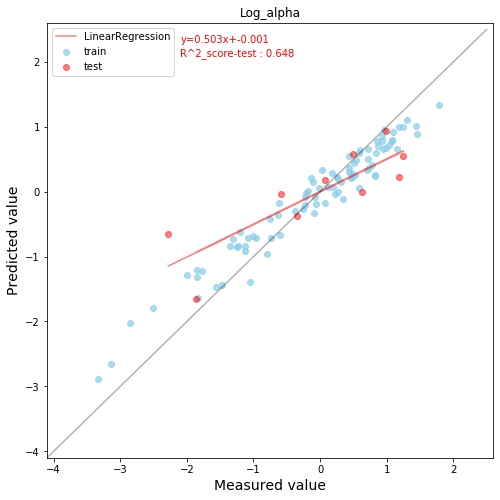

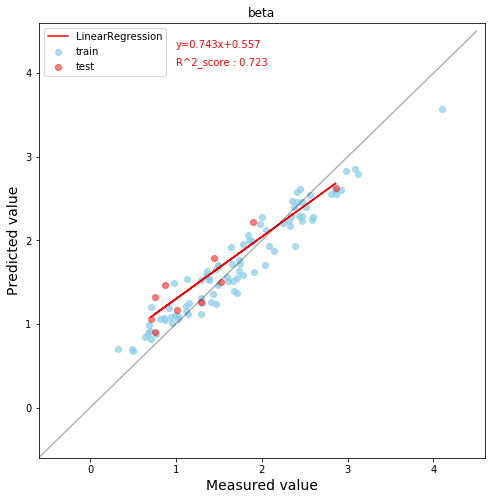

In [33]:
#================================結果の可視化===================================
compare_meas_pred_train = pd.concat([train3_y_La.reset_index(drop=True), pred3_train_La_inv, 
                                     train3_y_b.reset_index(drop=True), pred3_train_b_inv], axis = 1)
compare_meas_pred_test = pd.concat([test3_y_La.reset_index(drop=True), pred3_test_La_inv,
                                    test3_y_b.reset_index(drop=True), pred3_test_b_inv], axis = 1)
compare_meas_pred_addtest = pd.concat([pred3_addtest_La_inv, pred3_addtest_b_inv], axis = 1)

## グラフ化------------------------------------------------------------------
print ('\n【結果の可視化】')
## Log_alphaについて---------------------------------------------------------
meas_train = compare_meas_pred_train['Log_alpha']
pred_train = compare_meas_pred_train['pred_tr_La']
meas_test = compare_meas_pred_test['Log_alpha']
pred_test = compare_meas_pred_test['pred_ts_La']

fig = plt.figure (figsize=(8,8))
ax = fig.add_subplot (111)
ax.scatter (meas_train, pred_train, alpha=0.7, color='skyblue', label='train')
ax.scatter (meas_test, pred_test, alpha=0.5, color='red', label='test')

a, b = np.polyfit (meas_test, pred_test, 1)
y = a * meas_test + b
ax.plot (meas_test, y, alpha=0.5, color='red', label='LinearRegression')
ax.text (-2.1, 2.3, 'y='+ str (round(a,3)) + 'x+' + str (round(b,3)), color='red')

plt.ylim(-4.1,2.6)
plt.xlim(-4.1,2.6)

xguide = np.arange(-4.1, 2.6, 0.1)
yguide = xguide
ax.plot(xguide, yguide, alpha=0.3, color='black')

ax.text (-2.1, 2.1, 'R^2_score-test : '+ str (round(r2_score(meas_test, pred_test),3)), color='red')

plt.title('Log_alpha')

plt.xlabel('Measured value', fontsize=14)
plt.ylabel('Predicted value', fontsize=14)
plt.legend()
plt.show()

## betaについて---------------------------------------------------------
meas_train = compare_meas_pred_train['beta']
pred_train = compare_meas_pred_train['pred_tr_b']
meas_test = compare_meas_pred_test['beta']
pred_test = compare_meas_pred_test['pred_ts_b']

fig = plt.figure (figsize=(8,8))
ax = fig.add_subplot (111)
ax.scatter (meas_train, pred_train, alpha=0.7, color='skyblue', label='train')
ax.scatter (meas_test, pred_test, alpha=0.5, color='red', label='test')

a, b = np.polyfit (meas_test, pred_test, 1)
y = a * meas_test + b
ax.plot (meas_test, y, color='red', label='LinearRegression')
ax.text (1.0, 4.3, 'y='+ str (round(a,3)) + 'x+' + str (round(b,3)), color='red')


plt.ylim(-0.6,4.6)
plt.xlim(-0.6,4.6)

xguide = np.arange(-0.6, 4.6, 0.1)
yguide = xguide
ax.plot(xguide, yguide, alpha=0.3, color='black')

ax.text (1.0, 4.1, 'R^2_score : '+ str (round(r2_score(meas_test, pred_test),3)), color='red')

plt.title('beta')

plt.xlabel('Measured value', fontsize=14)
plt.ylabel('Predicted value', fontsize=14)
plt.legend()
plt.show()


## 実測値と予測値の比較グラフ

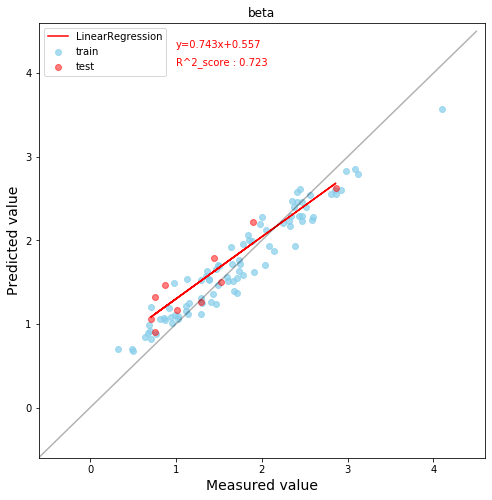